In [2]:
import glob
import multiprocessing
import random
import time
import enum

import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchio as tio
import torchvision
from tqdm import tqdm

from unet import UNet

from scripts.utils.memory import get_total_memory
from scripts.utils.visualization import visualize_subject, visualize_slice
from scripts.utils.loading import get_subjects_names
from scripts.load_data import load_2D, load_3D
seed = 42
random.seed(seed)
torch.manual_seed(seed)
%config InlineBackend.figure_format = 'retina'
num_workers = multiprocessing.cpu_count()
plt.rcParams['figure.figsize'] = 12, 6

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

%load_ext autoreload
%autoreload 2

print('Last run on', time.ctime())
print('TorchIO version:', tio.__version__)
print('Device:', device)


/home/ids/mahdi-22/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Last run on Fri Jul  7 13:55:44 2023
TorchIO version: 0.18.92
Device: cuda


# Data Loading and Visualization

In [3]:
metadata_path = "Data/M&Ms/OpenDataset/211230_M&Ms_Dataset_information_diagnosis_opendataset.csv"
metadata = pd.read_csv(metadata_path, index_col=1).drop(columns="Unnamed: 0")
metadata.head(5)

,VendorName,Vendor,Centre,ED,ES,Age,Pathology,Sex,Height,Weight
External code,,,,,,,,,,
A0S9V9,Siemens,A,1,0,9,67,DCM,M,180.0,88.0
A1D0Q7,Philips,B,2,0,9,79,HCM,F,NaN,88.0
A1D9Z7,Siemens,A,1,22,11,53,HCM,M,175.0,75.0
A1E9Q1,Siemens,A,1,0,9,16,DCM,M,175.0,75.0
A1K2P5,Canon,D,5,33,11,35,DCM,F,170.0,NaN


  0%|          | 0/150 [00:00<?, ?it/s]

100%|██████████| 150/150 [00:24<00:00,  6.01it/s]


Training/Labeled/ Dataset size: 150 subjects
Total memory for train:  410.75 MB
Subject(Keys: ('image', 'seg', 'id'); images: 2)
ScalarImage(shape: (2, 128, 128, 12); spacing: (1.22, 1.12, 9.60); orientation: PIR+; dtype: torch.FloatTensor; memory: 1.5 MiB)
LabelMap(shape: (2, 128, 128, 12); spacing: (1.22, 1.12, 9.60); orientation: PIR+; dtype: torch.FloatTensor; memory: 1.5 MiB)


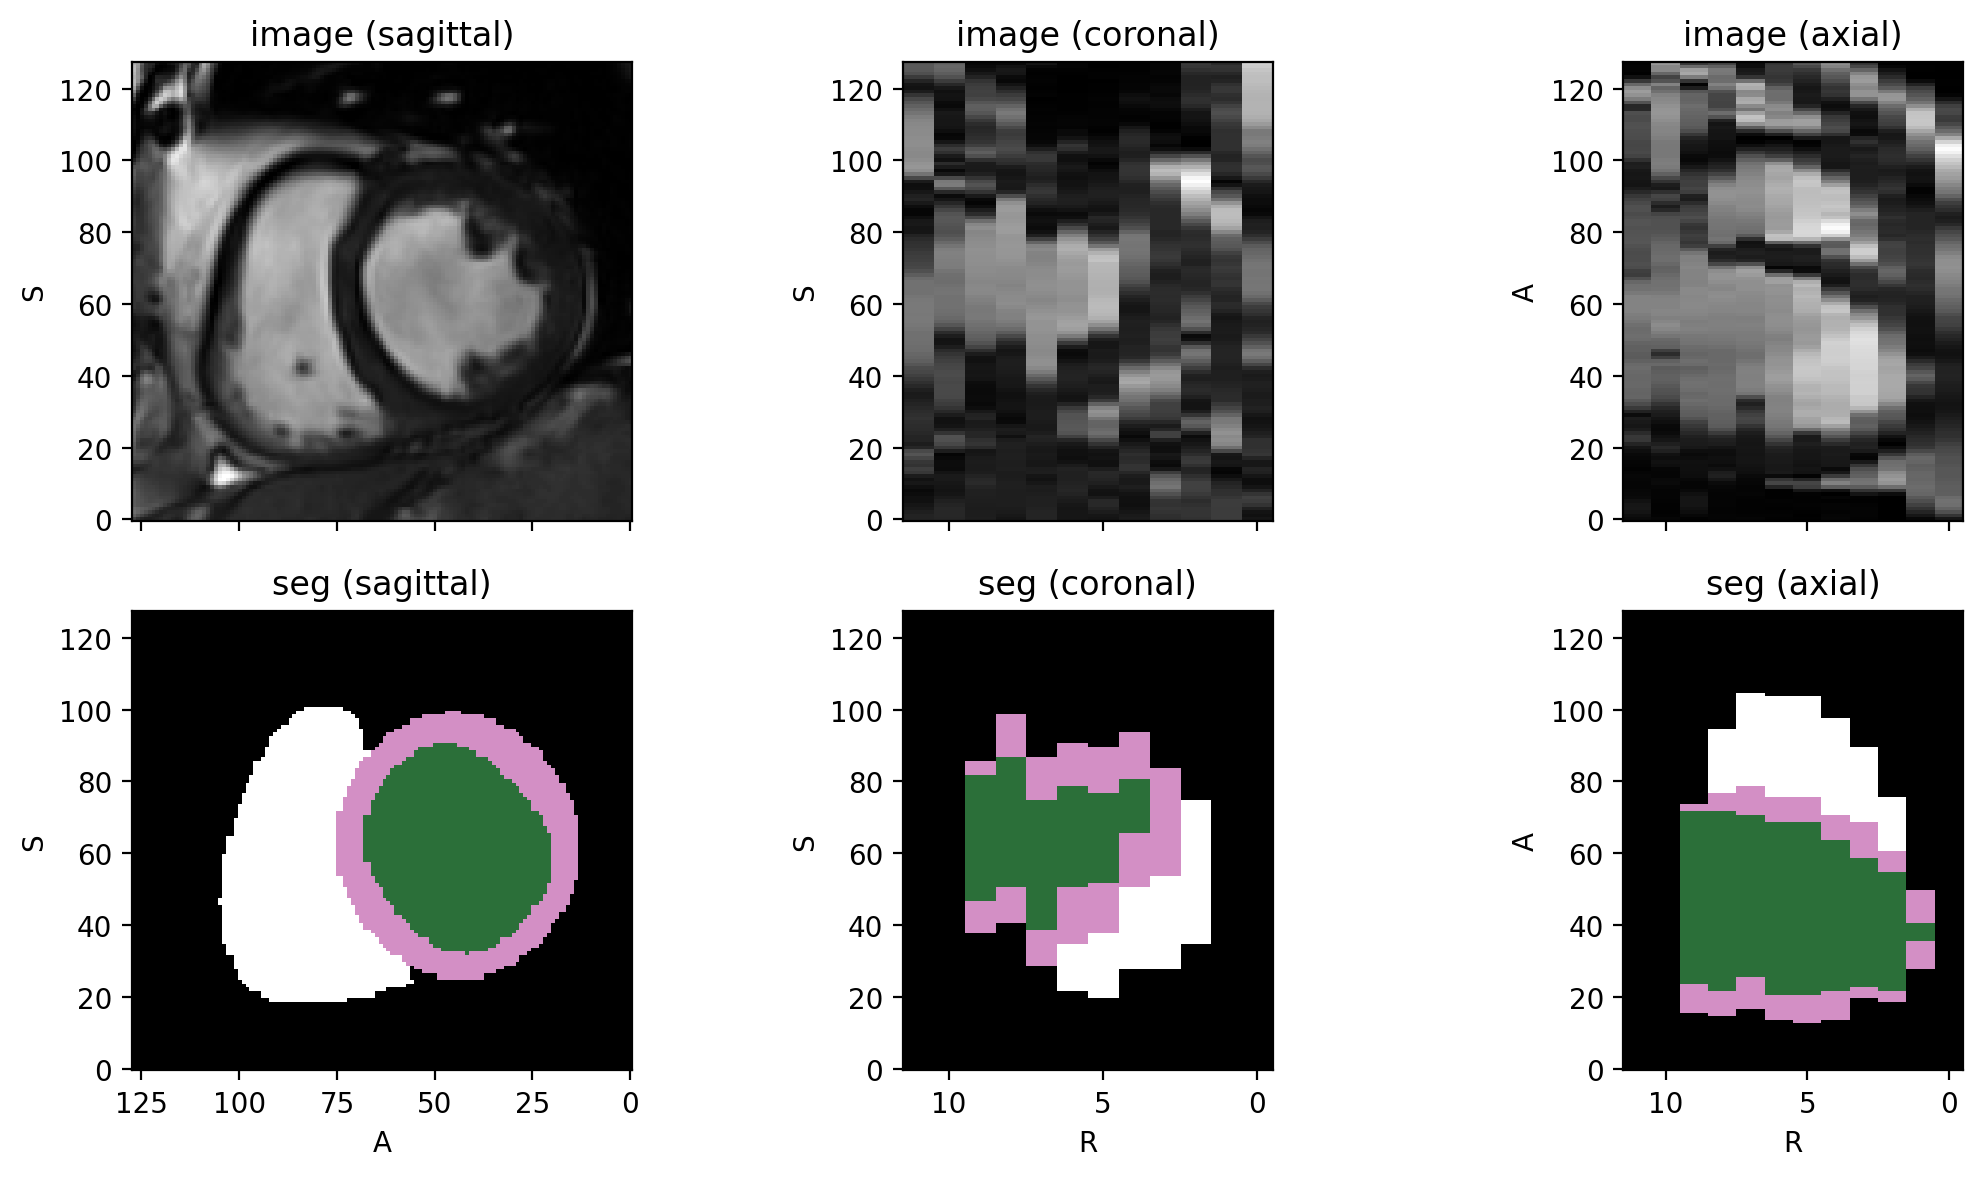

In [4]:
train_dataset_3D = load_3D("Training/Labeled/")
print("Total memory for train: ", get_total_memory(train_dataset_3D))
one_subject = train_dataset_3D[0]
visualize_subject(one_subject)

  0%|          | 0/150 [00:00<?, ?it/s]

100%|██████████| 150/150 [00:23<00:00,  6.32it/s]


Training/Labeled/ Dataset size: 3286 subjects


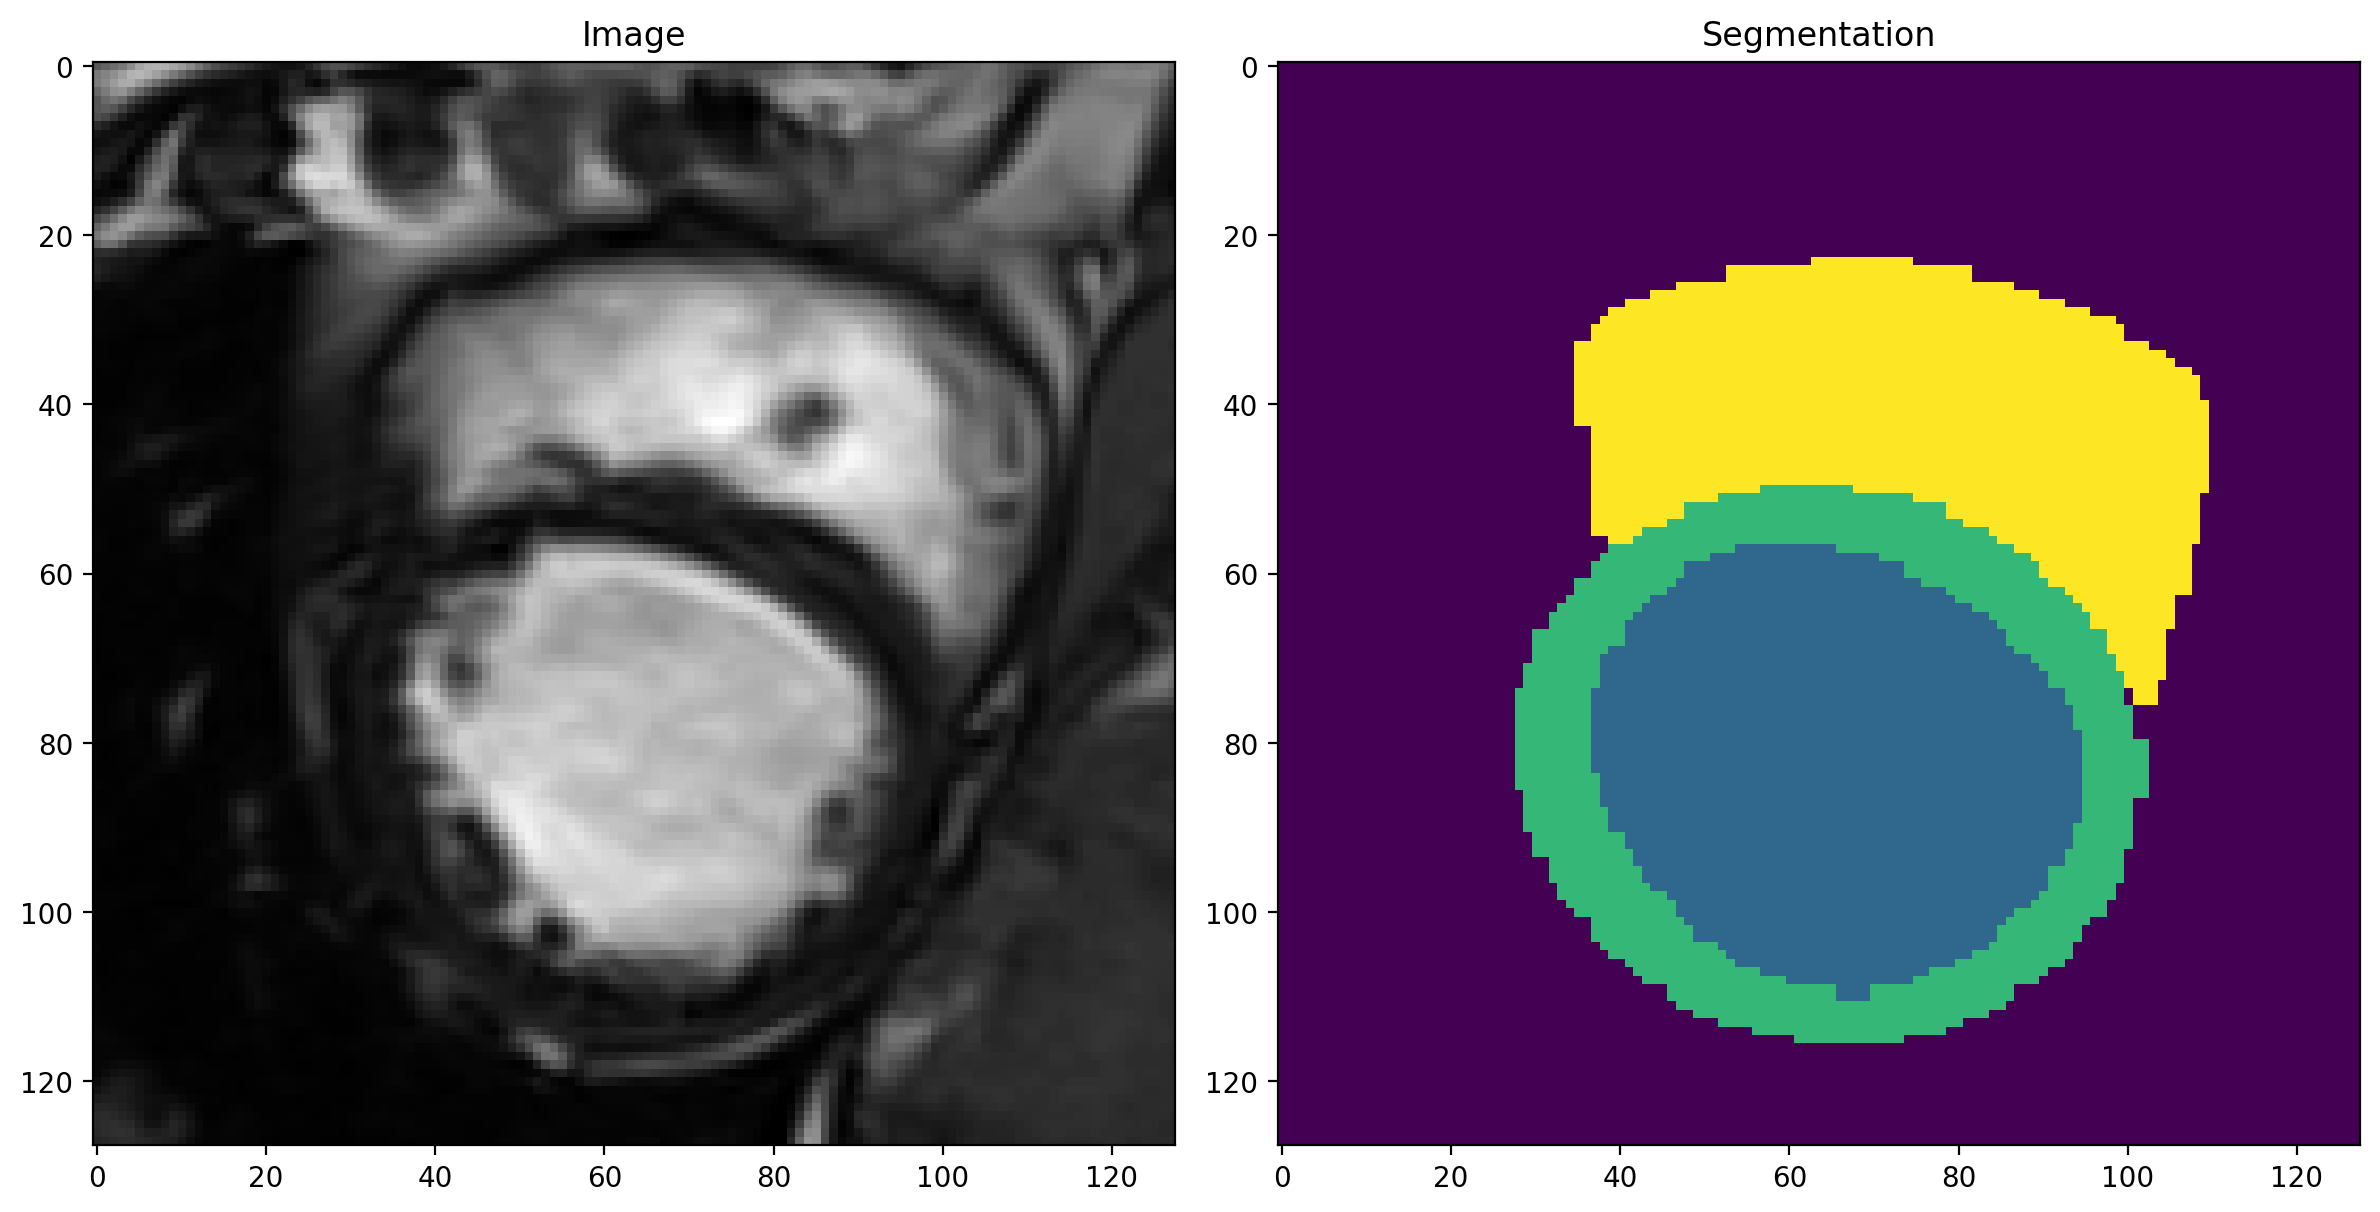

In [5]:
train_dataset = load_2D("Training/Labeled/")
image = train_dataset[10][0]
seg = train_dataset[10][1]
visualize_slice(image, seg)

In [6]:
# # C8J7L5 was removed from valid
valid_dataset = load_2D("Validation/")
# #E3F5U2, C8O0P2 were removed from test
# test_dataset = load_2D("Testing/")

100%|██████████| 33/33 [00:05<00:00,  6.40it/s]


Validation/ Dataset size: 786 subjects


# Unet

### Training

In [7]:
def imshow(img, seg=None):
    npimg = img.numpy()[0]
    plt.figure(figsize=(4,8))
    plt.imshow(npimg, "gray")
    if seg is not None:
        seg = seg.numpy()[0]
        cmap = plt.colormaps.get_cmap('jet')
        masked = np.ma.masked_where(seg == 0, seg)
        plt.imshow(masked, cmap=cmap, alpha=0.7)

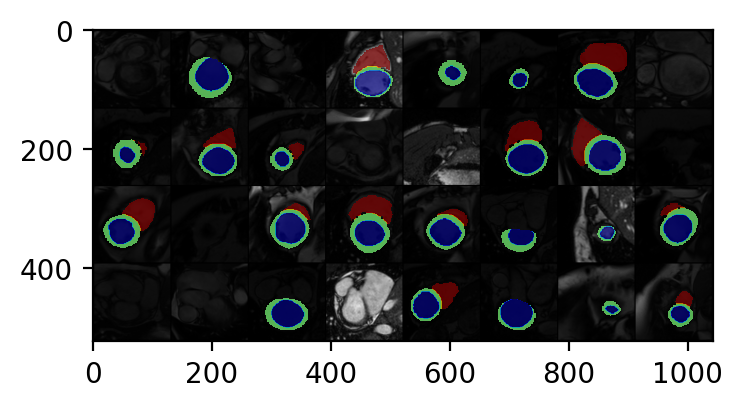

In [8]:
batch_size = 32
num_classes = 4


training_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=10,
    )

validation_loader = torch.utils.data.DataLoader(
    valid_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=10
    )

dataiter = iter(training_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images), torchvision.utils.make_grid(labels))

modelv1: num_encoding_blocks = 4

modelv2: num_encoding_blocks = 3

In [9]:
num_epochs = 30
total_steps = len(training_loader)

model = UNet(
    in_channels=1,
    out_classes=4,
    dimensions=2,
    num_encoding_blocks=5,
    out_channels_first_layer=16,
    normalization='batch',
    upsampling_type='linear',
    padding=True,
    activation='PReLU',
).to(device)
model.to(device)


optimizer = torch.optim.AdamW(model.parameters())
criterion = nn.BCEWithLogitsLoss()

losses = []
valid_losses = []
for epoch in tqdm(range(num_epochs)):
    epoch_loss = 0
    model.train()
    for i, (images_batch, labels_batch) in enumerate(training_loader):
        images_batch = images_batch.to(device)
        labels_batch = labels_batch.squeeze().long().to(device)
        labels_onehot = F.one_hot(labels_batch, num_classes=4).permute(0, 3, 1, 2).float().to(device)

        optimizer.zero_grad()
        outputs = model(images_batch)

        loss = criterion(outputs, labels_onehot)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    losses.append(loss.item())

    model.eval()
    valid_images, valid_labels = valid_dataset[:][0], valid_dataset[:][1]
    valid_images = valid_images.to(device)
    valid_labels = valid_labels.squeeze().long().to(device)
    valid_labels_onehot = F.one_hot(valid_labels, num_classes=4).permute(0, 3, 1, 2).float().to(device)
    

    with torch.no_grad():
        valid_outputs = model(valid_images)
        valid_loss = criterion(valid_outputs, valid_labels_onehot)
        valid_losses.append(valid_loss.item())

    if epoch % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}]], Loss: {epoch_loss/total_steps:.4f}, Validation Loss: {valid_loss.item():.4f}")


torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'metadata': {
        'num_epochs': num_epochs,
        'total_steps': total_steps,
        'losses': losses,
        'valid_losses': valid_losses
    }
}, 'models/modelv2.pth')



  3%|▎         | 1/30 [00:09<04:33,  9.44s/it]

Epoch [1/30]], Loss: 0.4458, Validation Loss: 0.3488


 37%|███▋      | 11/30 [01:32<02:38,  8.34s/it]

Epoch [11/30]], Loss: 0.0347, Validation Loss: 0.0782


 70%|███████   | 21/30 [02:56<01:15,  8.37s/it]

Epoch [21/30]], Loss: 0.0237, Validation Loss: 0.0617


100%|██████████| 30/30 [04:11<00:00,  8.38s/it]


In [10]:
# num_epochs = 100
# total_steps = len(training_loader)

# model = UNet(
#     in_channels=1,
#     out_classes=4,
#     dimensions=2,
#     num_encoding_blocks=4,
#     out_channels_first_layer=8,
#     normalization='batch',
#     upsampling_type='linear',
#     padding=True,
#     activation='PReLU',
# ).to(device)
# model.to(device)


# optimizer = torch.optim.AdamW(model.parameters())
# criterion = nn.BCEWithLogitsLoss()


checkpoint = torch.load('models/modelv3.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
meta = checkpoint['metadata']

num_epochs = meta['num_epochs']
total_steps = meta['total_steps']
losses = meta['losses']
valid_losses = meta['valid_losses']

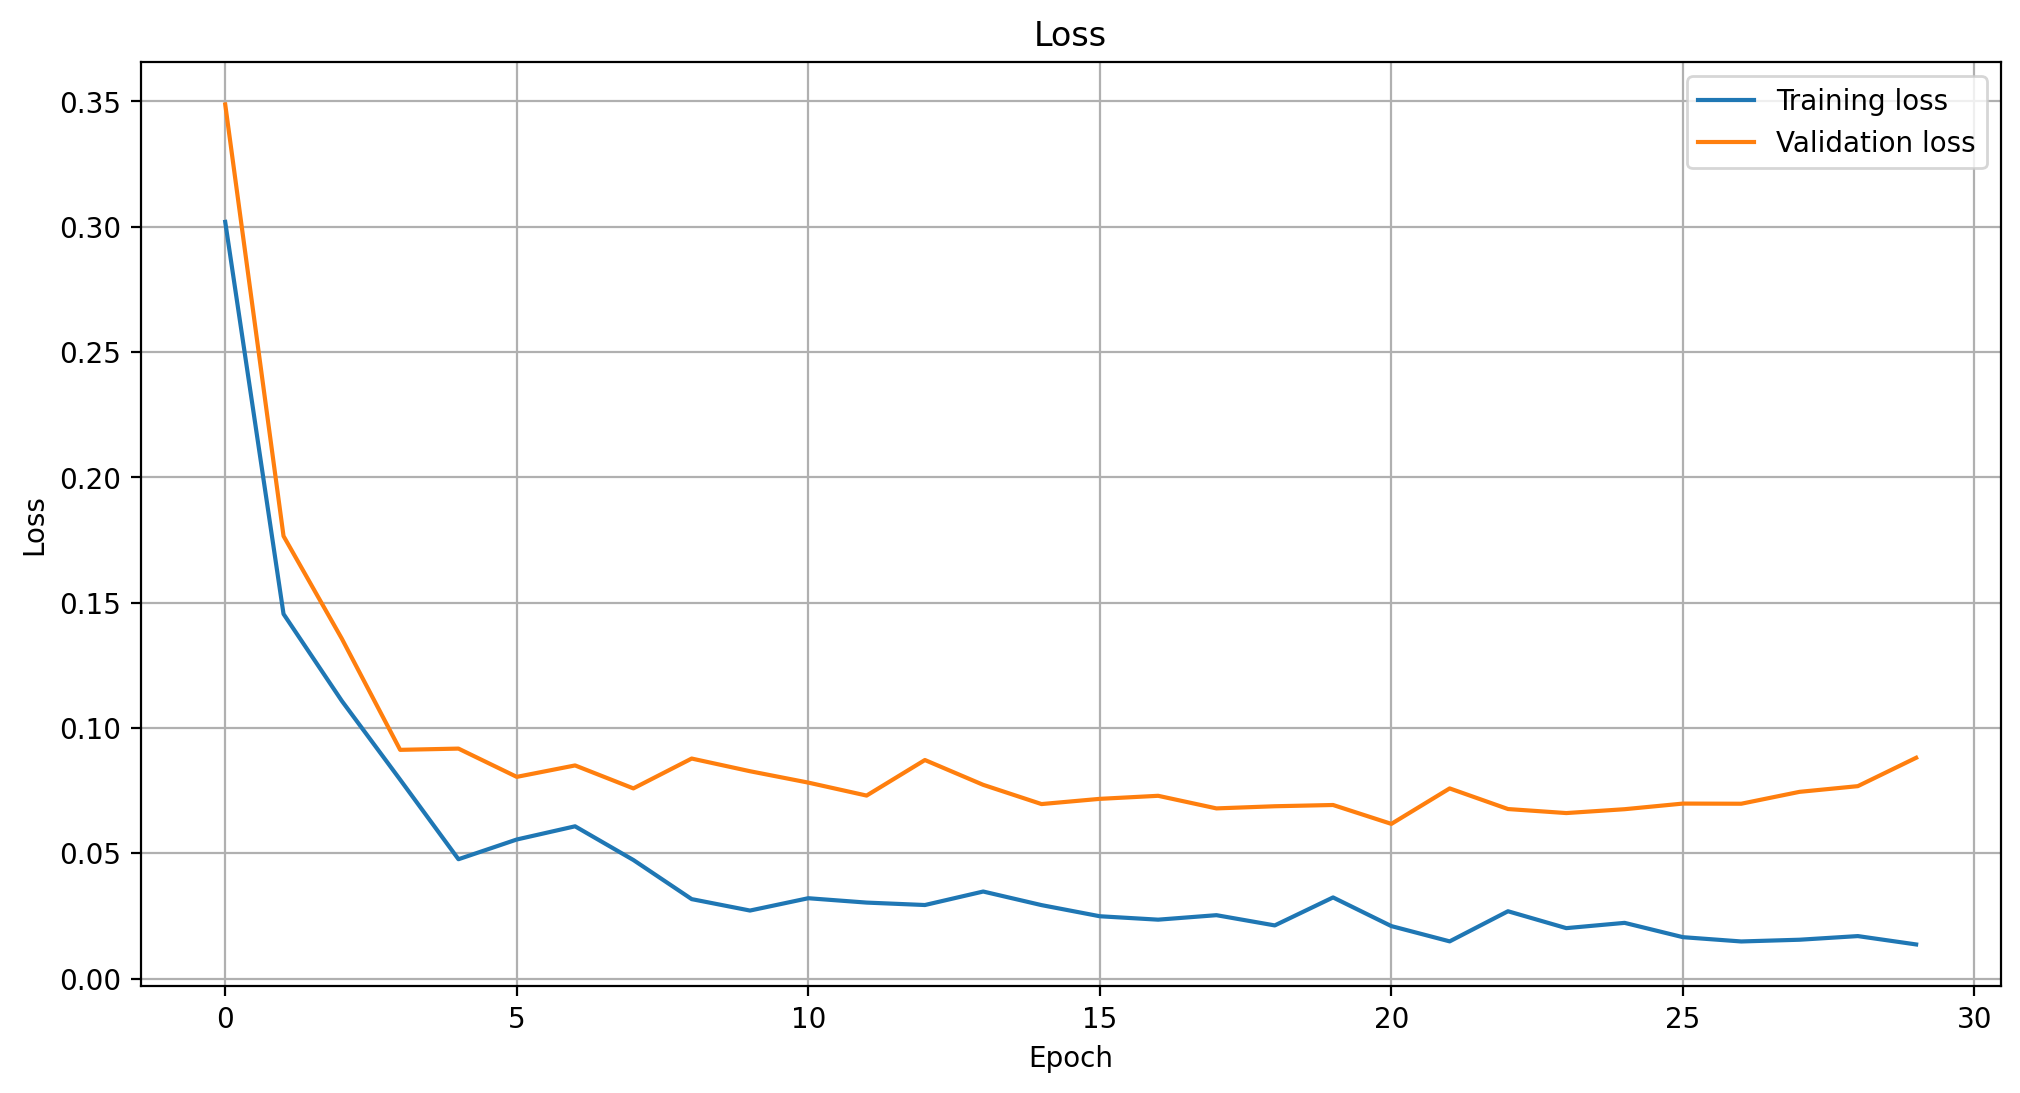

In [11]:
plt.plot(range(num_epochs) , losses, label="Training loss")
plt.plot(range(num_epochs) , valid_losses, label="Validation loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss")
plt.grid(True)
plt.legend()
plt.show()

### Visualize results

In [12]:
valid_iter = iter(validation_loader)

In [13]:
validation_batch = next(valid_iter)
images, ground_truths = validation_batch
images = images.to(device)

with torch.no_grad():
    output = model(images)

probabilities = torch.softmax(output, dim=1)
_, predictions = torch.max(probabilities, dim=1)

predictions = predictions.cpu()


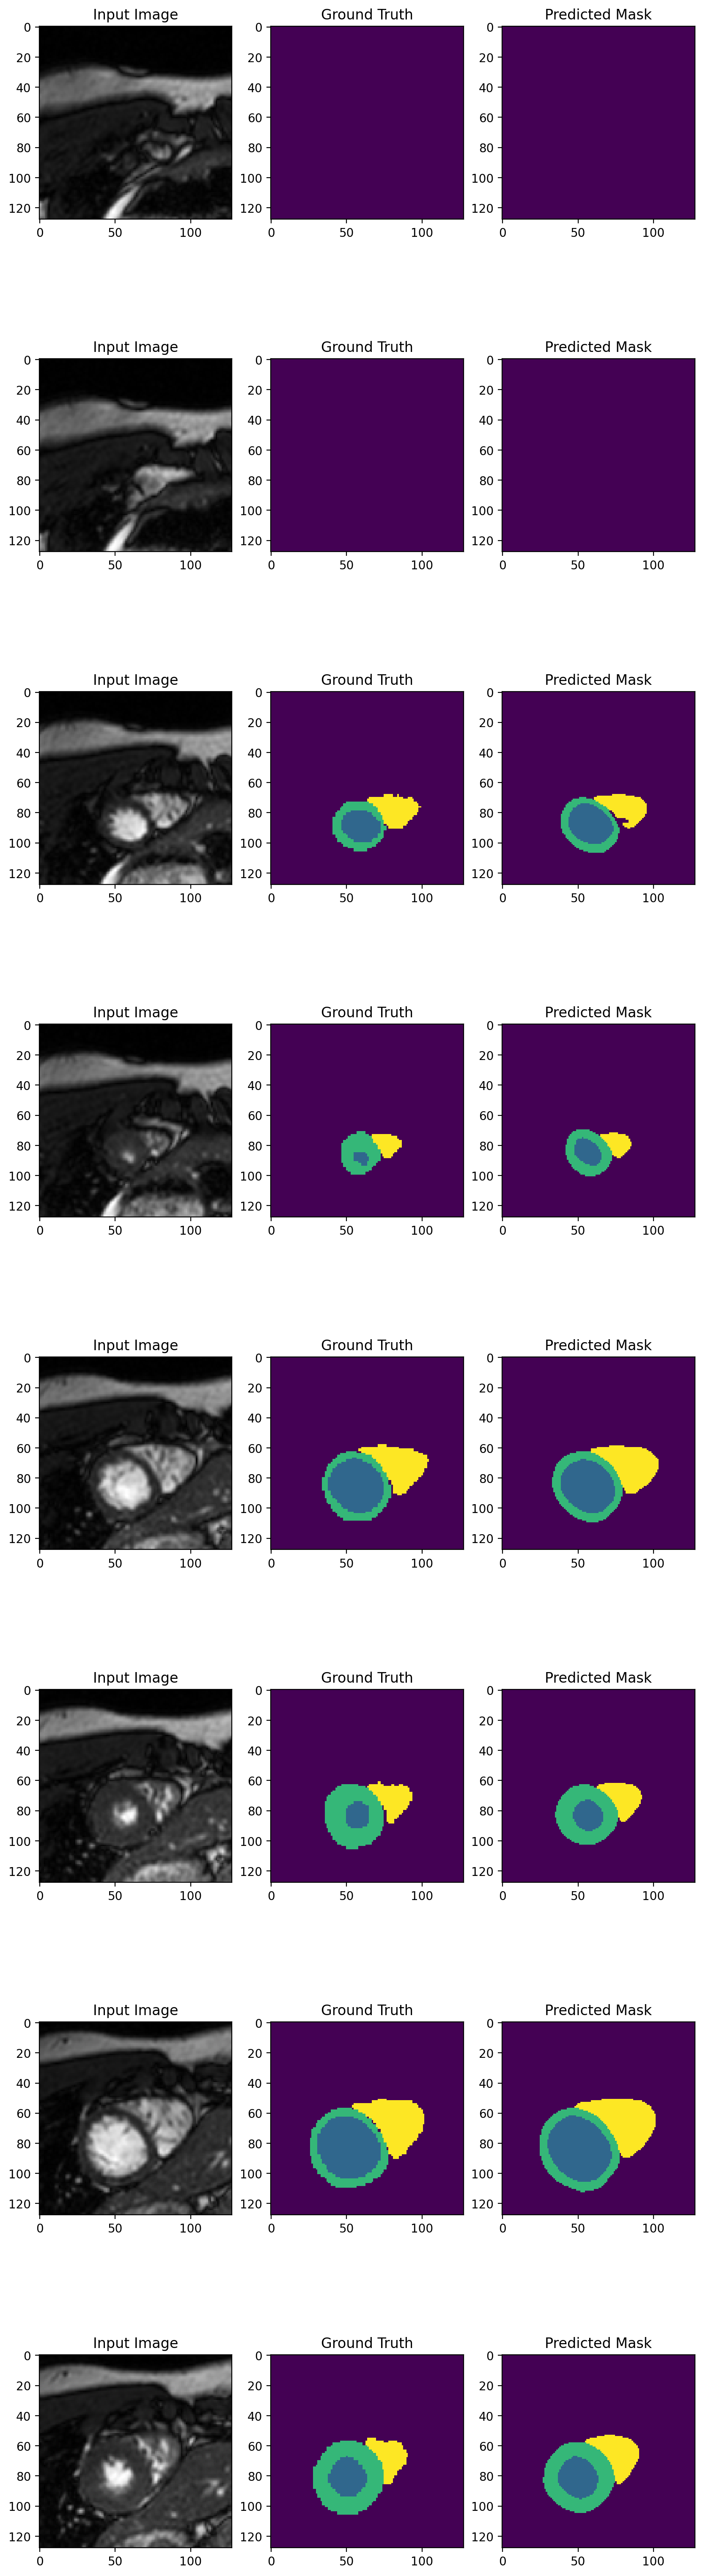

In [14]:
n_examples = 8
plt.figure(figsize=(10, 5 * n_examples))

for i in range(n_examples):
    input_image = images[i].cpu()
    ground_truth = ground_truths[i].cpu()
    predicted_mask = predictions[i]

    input_image = input_image.permute(1, 2, 0).numpy()
    ground_truth = ground_truth.permute(1, 2, 0).numpy()
    predicted_mask = predicted_mask.numpy()

    plt.subplot(n_examples, 3, i*3 + 1)
    plt.imshow(input_image, cmap='gray')
    plt.title('Input Image')

    plt.subplot(n_examples, 3, i*3 + 2)
    plt.imshow(ground_truth)
    plt.title('Ground Truth')

    plt.subplot(n_examples, 3, i*3 + 3)
    plt.imshow(predicted_mask)
    plt.title('Predicted Mask')

plt.show()

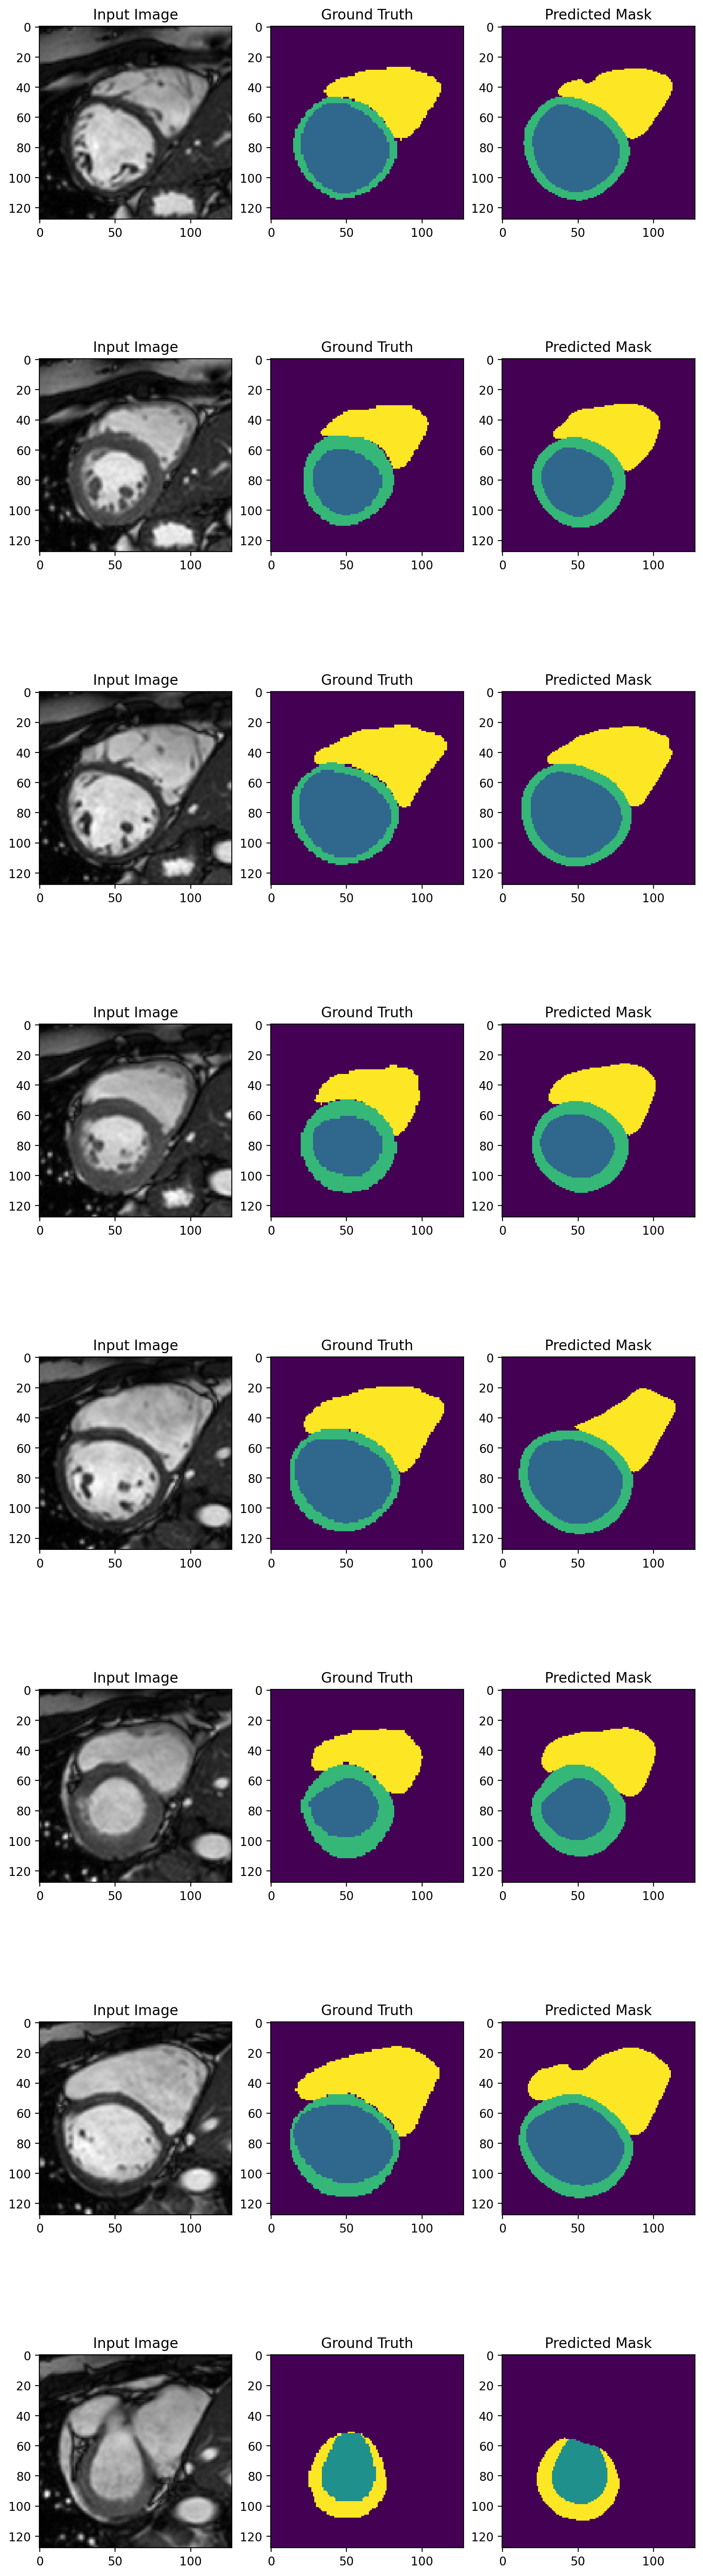

In [15]:
validation_batch = next(valid_iter)
images, ground_truths = validation_batch
images = images.to(device)

with torch.no_grad():
    output = model(images)

probabilities = torch.softmax(output, dim=1)
_, predictions = torch.max(probabilities, dim=1)

predictions = predictions.cpu()

n_examples = 8
plt.figure(figsize=(10, 5 * n_examples))

for i in range(n_examples):
    input_image = images[i].cpu()
    ground_truth = ground_truths[i].cpu()
    predicted_mask = predictions[i]

    input_image = input_image.permute(1, 2, 0).numpy()
    ground_truth = ground_truth.permute(1, 2, 0).numpy()
    predicted_mask = predicted_mask.numpy()

    plt.subplot(n_examples, 3, i*3 + 1)
    plt.imshow(input_image, cmap='gray')
    plt.title('Input Image')

    plt.subplot(n_examples, 3, i*3 + 2)
    plt.imshow(ground_truth)
    plt.title('Ground Truth')

    plt.subplot(n_examples, 3, i*3 + 3)
    plt.imshow(predicted_mask)
    plt.title('Predicted Mask')

plt.show()

### Visualize the predictions for each vendor

In [16]:
test_dataset = load_3D("Testing/")

  0%|          | 0/134 [00:00<?, ?it/s]

100%|██████████| 134/134 [00:22<00:00,  6.00it/s]

Testing/ Dataset size: 134 subjects


In [17]:
# Get data for one subject
one_subject = test_dataset[10]

image = one_subject.image.data
labels = one_subject.seg.data
id = one_subject.id

# Get metadata
vendor = metadata.loc[id].Vendor
vendor

'D'

In [18]:
# Make predictions
c, x, y, z = image.shape
stacked = image.permute((0,3,1,2)).reshape(c*z, 1 ,x, y)

In [19]:
stacked = stacked.to(device)

with torch.no_grad():
    output = model(stacked)

probabilities = torch.softmax(output, dim=1)
_, predictions = torch.max(probabilities, dim=1)

predictions = predictions.cpu()
stacked = stacked.cpu()

print(predictions.shape)


torch.Size([24, 128, 128])


In [20]:
predictions = torch.stack((predictions[:z],predictions[z:]))
predictions = predictions.permute((0,2,3,1)).float()
pred = tio.LabelMap(tensor=one_subject.seg.data, affine = one_subject.seg.affine, dtype=torch.FloatTensor)
pred.set_data(predictions)

In [21]:
new_subject = tio.Subject(
    image = one_subject.image,
    seg = one_subject.seg,
    prediction = pred
)

Subject(Keys: ('image', 'seg', 'prediction'); images: 3)
ScalarImage(shape: (2, 128, 128, 12); spacing: (1.08, 1.00, 10.00); orientation: LIP+; dtype: torch.FloatTensor; memory: 1.5 MiB)
LabelMap(shape: (2, 128, 128, 12); spacing: (1.08, 1.00, 10.00); orientation: LIP+; dtype: torch.FloatTensor; memory: 1.5 MiB)


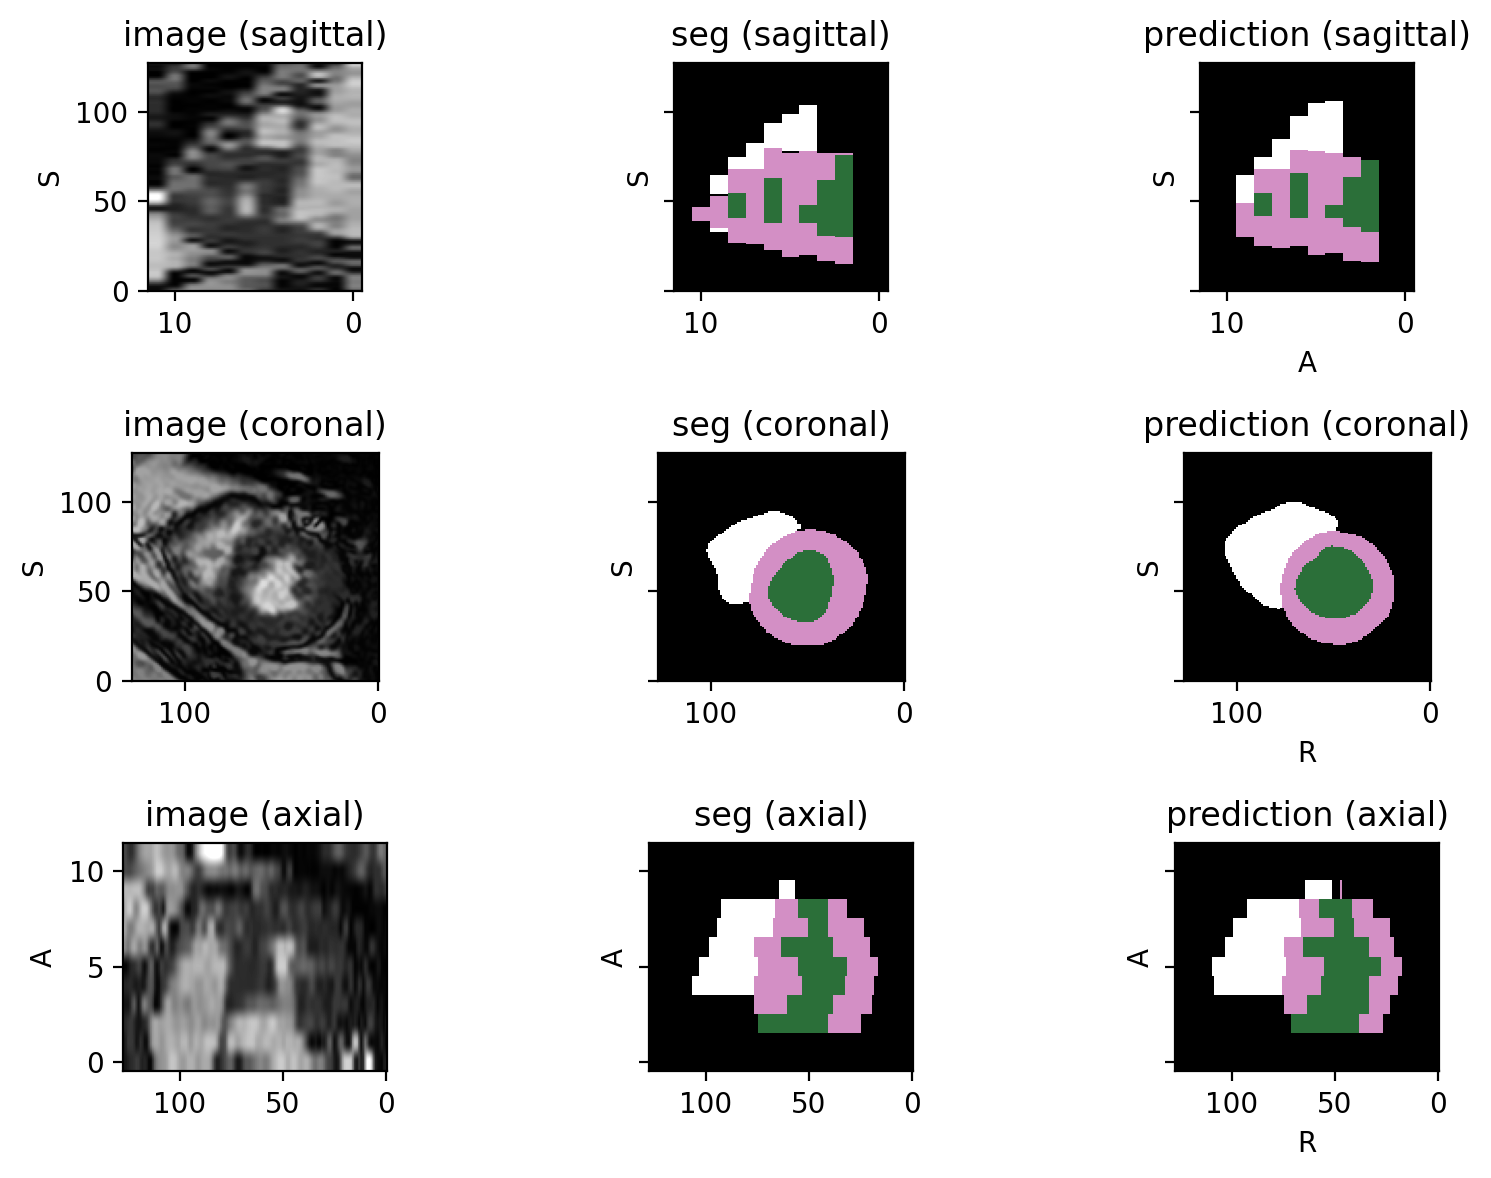

In [22]:
visualize_subject(new_subject)

### Dice Coefficient

In [23]:
def dice_coef(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = (y_true_f * y_pred_f).sum().item()
    smooth = 0.0001
    return (2. * intersection + smooth) / (y_true_f.sum().item() + y_pred_f.sum().item() + smooth)

def dice_coef_multilabel(y_true, y_pred, numLabels):
    dice=0
    for index in range(numLabels):
        dice += dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index])
    return dice/numLabels # taking average

num_class = 4

In [24]:
results= {}
for data_dir in ["Training/Labeled/", "Validation/","Testing/"]:
    dataset_3D = load_3D(data_dir)

    n = {"A":0, "B":0,"C":0,"D":0}
    dc = {"A":0., "B":0.,"C":0.,"D":0.}
    for i in range(len(dataset_3D)):
        # Get data for one subject
        one_subject = dataset_3D[i]

        image = one_subject.image.data
        labels = one_subject.seg.data
        id = one_subject.id

        # Get metadata
        vendor = metadata.loc[id].Vendor
        


        # Make predictions
        c, x, y, z = image.shape
        stacked = image.permute((0,3,1,2)).reshape(c*z, 1 ,x, y)
        labels_stacked = labels.permute((0,3,1,2)).reshape(c*z ,x, y).long()




        labels_onehot = F.one_hot(labels_stacked, num_classes=4)
        stacked = stacked.to(device)

        with torch.no_grad():
            output = model(stacked)

        probabilities = torch.softmax(output, dim=1)
        _, predictions = torch.max(probabilities, dim=1)

        predictions = predictions.cpu()
        stacked = stacked.cpu()
        predictions_onehot = F.one_hot(predictions, num_classes=4)

        d = dice_coef_multilabel(labels_onehot, predictions_onehot, 4)

        n[vendor] += 1
        dc[vendor] += d

    for v in dc.keys():
        if n[v]!=0:
            dc[v] /= n[v]

    results[data_dir] = {"dc": dc, "n": n}

  0%|          | 0/150 [00:00<?, ?it/s]

100%|██████████| 150/150 [00:24<00:00,  6.13it/s]


Training/Labeled/ Dataset size: 150 subjects


100%|██████████| 33/33 [00:05<00:00,  6.02it/s]


Validation/ Dataset size: 33 subjects


100%|██████████| 134/134 [00:22<00:00,  5.88it/s]


Testing/ Dataset size: 134 subjects


In [25]:
for k1, v1 in results.items():
    print(k1)

    print("\tn:")
    for k3, v3 in v1["n"].items():
        print("\t\t", k3, ": ", v3)
        
    print("\tdc:")
    for k3, v3 in v1["dc"].items():
        print("\t\t", k3, ": {:.2%}".format(v3))


Training/Labeled/
	n:
		 A :  75
		 B :  75
		 C :  0
		 D :  0
	dc:
		 A : 94.56%
		 B : 95.04%
		 C : 0.00%
		 D : 0.00%
Validation/
	n:
		 A :  4
		 B :  10
		 C :  9
		 D :  10
	dc:
		 A : 87.58%
		 B : 88.64%
		 C : 87.01%
		 D : 81.14%
Testing/
	n:
		 A :  16
		 B :  40
		 C :  38
		 D :  40
	dc:
		 A : 89.12%
		 B : 86.72%
		 C : 85.36%
		 D : 86.03%
